##  Chapter 8: Linear Unsupervised Learning

# 8.5  The classic PCA solution

In this Section we describe a 'closed-form' minimizer of the PCA Least Squares / Autoencoder cost that is very commonly used in practice for applications ranging from data analysis (when using $K < N$ elements) and as an advanced form of input normalization (called PCA-sphereing, which is detailed in the next Chapter).  So often is it used that we refer to it as the *classic solution* to the PCA problem, and the orthogonal basis it provides are often called the *Principle Components* of a dataset.  This special set of orthogonal directions always provide a consistent 'skeleton' for any given dataset, with its members pointing in the *orthogonal directions of variance* of a dataset.  

In [1]:
# This code cell will not be shown in the HTML version of this notebook
# imports from custom library
import sys
sys.path.append('../../')
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ortho_group  # Requires version 0.18 of scipy

# custom libs
from mlrefined_libraries import unsupervised_library as unsuplib
from mlrefined_libraries import basics_library as baslib
from mlrefined_libraries import math_optimization_library as optlib
optimizers = optlib.optimizers
static_plotter = optlib.static_plotter.Visualizer()
datapath = '../../mlrefined_datasets/unsuperlearn_datasets/'

# plotting utilities
import matplotlib.pyplot as plt
from matplotlib import gridspec

# This is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

## 8.5.1 The classic PCA minimizer of the Autoencoder cost function

Before going into the derivation of this special minimizer of the Autoencoder cost function, let us summarize and illustrate (with a `Python` implementation) how this special solution is computed.  Denoting by $\mathbf{X}$ the *data matrix* - consisting of 

\begin{equation}
\mathbf{X} = 
\begin{bmatrix}
\vert  \,\,\,\,\,\,\, \vert  \,\,\,\,\,  \cdots  \,\,\,\,\, \vert \\
\,\, \mathbf{x}_1 \,\,\, \mathbf{x}_2 \,\,\, \cdots \,\,\, \mathbf{x}_P \\
\vert  \,\,\,\,\,\,\, \vert  \,\,\,\,\,  \cdots  \,\,\,\,\, \vert 
\end{bmatrix}
\end{equation}

the orthogonal basis provided by this special solution (called the *Principal Components* of a dataset) can be computed (as a minimum of the Autoencoder cost function) as the *eigenvectors* of the corresponding *correlation matrix* of this data

\begin{equation}
\text{covariance matrix of } \, \mathbf{X}: = \, \frac{1}{P}\mathbf{X}^{\,} \mathbf{X}^T
\end{equation}

Denoting the eigenvector/value decomposition of the covariance matrix 
$\frac{1}{P}\mathbf{X}^{\,} \mathbf{X}^T$ is given as

\begin{equation}
\frac{1}{P}\mathbf{X}^{\,} \mathbf{X}^T = \mathbf{V}^{\,}\mathbf{D}^{\,}\mathbf{V}^T
\end{equation}

then above the orthonormal basis we recover is given precisely by the eigenvectors above, i.e., $\mathbf{C} = \mathbf{V}$.  Again, these are referred to in the jargon of machine learning as the *principal components* of the data.  Moreover, the variance in each (principal component) direction is given precisely by the corresponding eigenvalue in $\mathbf{D}$.

<figure>
  <img src= '../../mlrefined_images/unsupervised_images/pca_classic.png' width="60%" height="auto" alt=""/>
  <figcaption>   
<strong>Figure 1:</strong> <em> The classic orthogonal PCA minimizer of the autoencoder cost function.  The elements of this basis point in the orthogonal directions of variance of the dataset, that is the orthogonal directions in which the dataset is most spread out.  Here we show a prototypical two-dimensional example where the recovered bases elements $\mathbf{c}_1 = d_1\mathbf{v}_1$ and $\mathbf{c}_2 = d_2\mathbf{v}_2$ are - as we will see below - constructed from the eigenvalues / vectors of the data covariance matrix.
</em>  </figcaption> 
</figure>

**A practical note:** in practice it is often helpful to slightly *regularize* a matrix prior to computing its eigenvalues/vectors to avoid natural numerical instability issues associated with their computation.  Here this means adding a small weighted identity $\lambda\mathbf{I}_{N\times N}$, where $\lambda \geq0$ is some small value (like e.g., $10^{-5}$), to the covariance matrix prior to computing its eigenvalues/vectors.  In short, in order to avoid computational trouble we typically compute principal components of the regularized covariance matrix $\frac{1}{P}\mathbf{X}^{\,} \mathbf{X}^T  + \lambda \mathbf{I}_{N\times N}$ instead of the raw covariance matrix itself.

### PCA algorithm  (classic orthogonal solution) 

<hr style="height:1px;border:none;color:#555;background-color:#555;">
<p style="line-height: 1.7;">
<strong>1:</strong>&nbsp;&nbsp; <strong>input:</strong> dataset $\mathbf{x}_1,...,\mathbf{x}_P$ stacked column-wise into a $N\times P$ data matrix $\mathbf{X}$, regularization parameter $\lambda$ <br>

<strong>2:</strong>&nbsp;&nbsp; <code>compute</code> mean of dataset $\boldsymbol{\mu} = \frac{1}{P}\sum_{p=1}^P\mathbf{x}_p$ and center data as $\mathbf{x}_p \longleftarrow \mathbf{x}_p - \boldsymbol{\mu}$ for $p=1,...,P$ <br> 

<strong>3:</strong>&nbsp;&nbsp; <code>compute</code>  $\frac{1}{P}\mathbf{X}\mathbf{X}^T + \lambda \mathbf{I}_{N\times N}$ (regularized correlation matrix)<br> 

<strong>4:</strong>&nbsp;&nbsp; <code>compute</code>
$\frac{1}{P}\mathbf{X}^{\,} \mathbf{X}^T +\lambda \mathbf{I}_{N\times N}= \mathbf{V}^{\,}\mathbf{D}^{\,}\mathbf{V}^T$ (eigenvalue / vector decomposition of correlation matrix)
<br>

<strong>5:</strong>&nbsp; <strong>output:</strong> optimal principal components PCA basis $\mathbf{V}$ and weights $\hat{\mathbf{w}}_p^{\,} = \mathbf{V}^T\mathbf{x}_p^{\,}$ for $p=1,...,P$ <br>

<hr style="height:1px;border:none;color:#555;background-color:#555;">
</p>

The ``Python`` cell below contains implementations of each fundamental idea here - data centering, principal component computation, and the PCA transformation.

In [2]:
def center(X):
    '''
    A function for normalizing each feaure dimension of an input array, mean-centering
    and division by its standard deviation
    
    '''
    X_means = np.mean(X,axis=1)[:,np.newaxis]
    X_normalized = X - X_means

    return X_normalized

def compute_pcs(X,lam):
    '''
    A function for computing the principal components of an input data matrix.  Both
    principal components and variance parameters (eigenvectors and eigenvalues of XX^T)
    are returned
    '''
    # create the correlation matrix
    P = float(X.shape[1])
    Cov = 1/P*np.dot(X,X.T) + lam*np.eye(X.shape[0])

    # use numpy function to compute eigenvalues / vectors of correlation matrix
    D,V = np.linalg.eigh(Cov)
    return D,V

def pca_transform_data(X,**kwargs):
    '''
    A function for producing the full PCA transformation on an input dataset X.  
    '''
    # user-determined number of principal components to keep, and regularizer penalty param
    num_components = X.shape[0]
    if 'num_components' in kwargs:
        num_components = kwargs['num_components']
    lam = 10**(-7)
    if 'lam' in kwargs:
        lam = kwargs['lam']
    
    # compute principal components
    D,V = compute_pcs(X,lam)
    V = V[:,-num_components:]
    D = D[-num_components:]

    # compute transformed data for PC space: V^T X
    W = np.dot(V.T,X)
    return W,V

#### <span style="color:#a50e3e;">Example 1: </span>  A simple example learning a spanning set via Principal Component Analysis 

In this example we illustrate the PCA basis - and transformed feature space - using a two-dimensional dataset.  This example mirrors the second part of Example 1 above precisely, only here we learn a basis of two spanning vectors via PCA instead of picking two fixed ones.  In the left panel we plot the mean-centered data, along with its two principal components (pointing in the two orthogonal directions of greatest variance in the dataset).  We find these by stacking the mean-centered data column-wise into the matrix $\mathbf{X}$ and determining the eigenvalue / vector decomposition of $\frac{1}{P}\mathbf{X}^{,}\mathbf{X}^T + \lambda \mathbf{I}_{N\times N}$, as detailed above.  We provide just this sort of  functionality in the ``Python`` cell below.

In the right panel we show the *transformed feature space* - whose coordinate axes are now the eigenvectors $\mathbf{v}_1$ and $\mathbf{v}_2$.  Each point $\mathbf{x}_p$ in the left panel corresponds to the tuned weight vector $\mathbf{w}_p$ in the right panel.  Remember: because the PCA basis is orthonormal these weights are given precisely as $\mathbf{w}_p = \mathbf{C}^T_{\,}\mathbf{x}^{\,}_p = \mathbf{V}^T_{\,}\mathbf{x}^{\,}_p$.  Also notice: in the transformed feature space provided by the PCA basis the data has simply been rotated so that its two orthogonal directions of variance perfectly align with the horizontal / vertical axes of the space.  

<IPython.core.display.Javascript object>


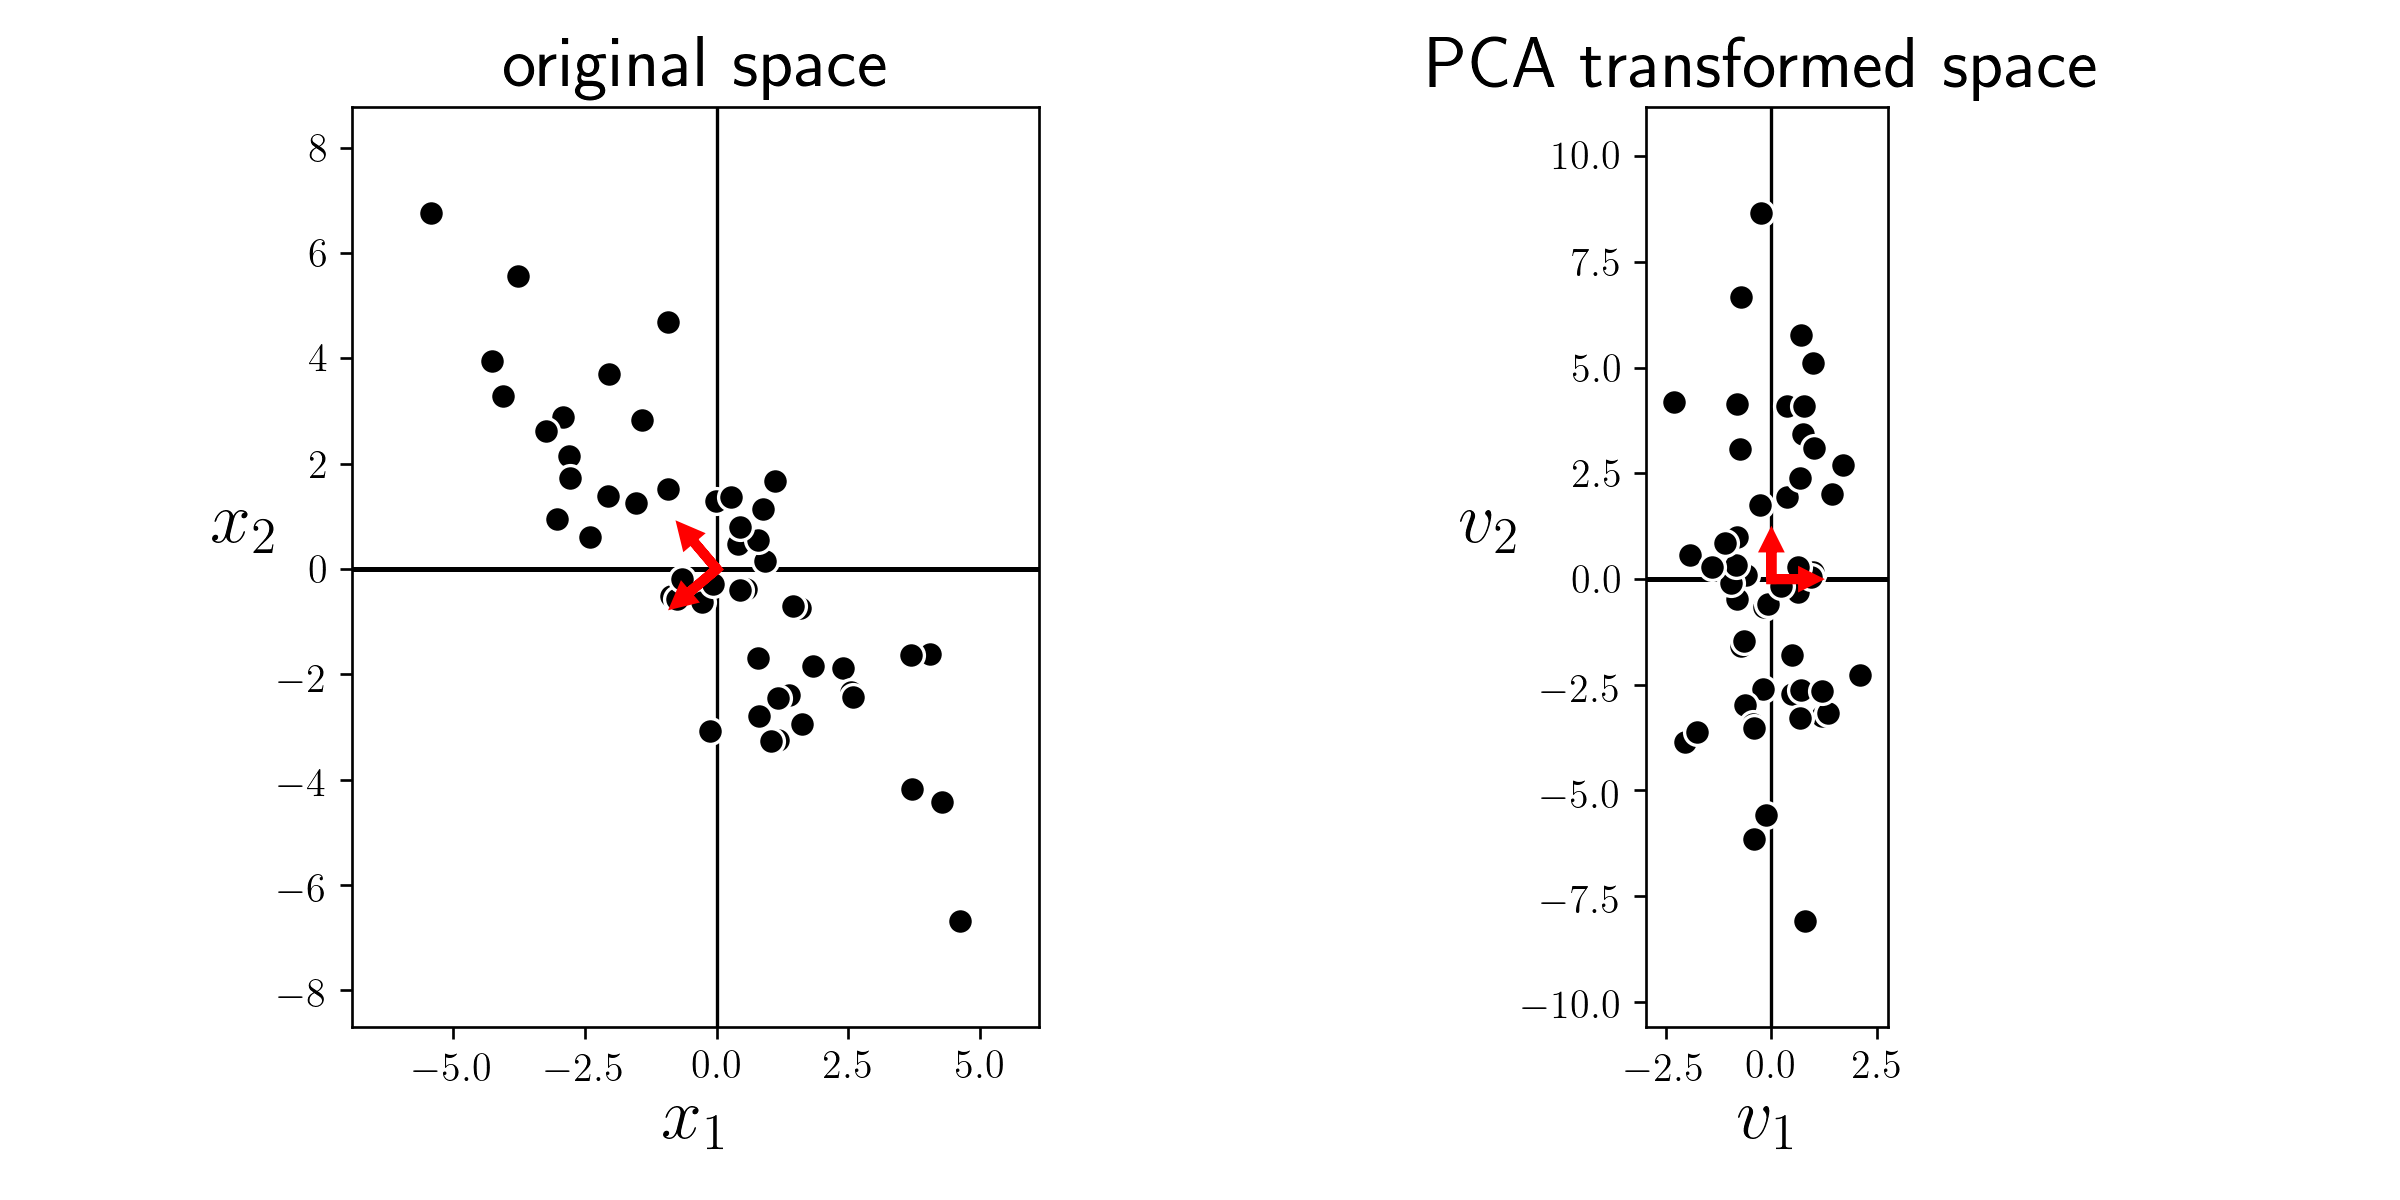

In [3]:
# load in dataset to perform PCA on, and mean-center
X_original = np.loadtxt(datapath + '2d_span_data.csv',delimiter=',')

# mean-center the data
X = center(X_original)

# compute the full PCA transformation of dataset
W,V = pca_transform_data(X)

# plot data in original and pca-transformed spaces
unsuplib.PCA_demos.pca_visualizer(X,W,V)

#### <span style="color:#a50e3e;">Example 2: </span>  Dimension reduction with the classic PCA basis

In this example we illustrate how the lassic PCA basis can be used to represent a three-dimensional dataset via its ideal two-dimensional linear subspace, using the first two principal components.  In the next cell we load in the dataset first shown in Example 3, compute the orthogonal PCA spanning set based on the eigenvectors of $\frac{1}{P}\mathbf{X}^{\,}\mathbf{X}^T + \lambda \mathbf{I}_{N\times N}$, and project the data onto the two-dimensional subspace spanned by the top two eigenvectors.  These top two eigenvectors and the subspace they span are shown in red in the left panel below, with the projected data in the subspace spanned by the top two eigenvectors are shown in the right panel.

<IPython.core.display.Javascript object>


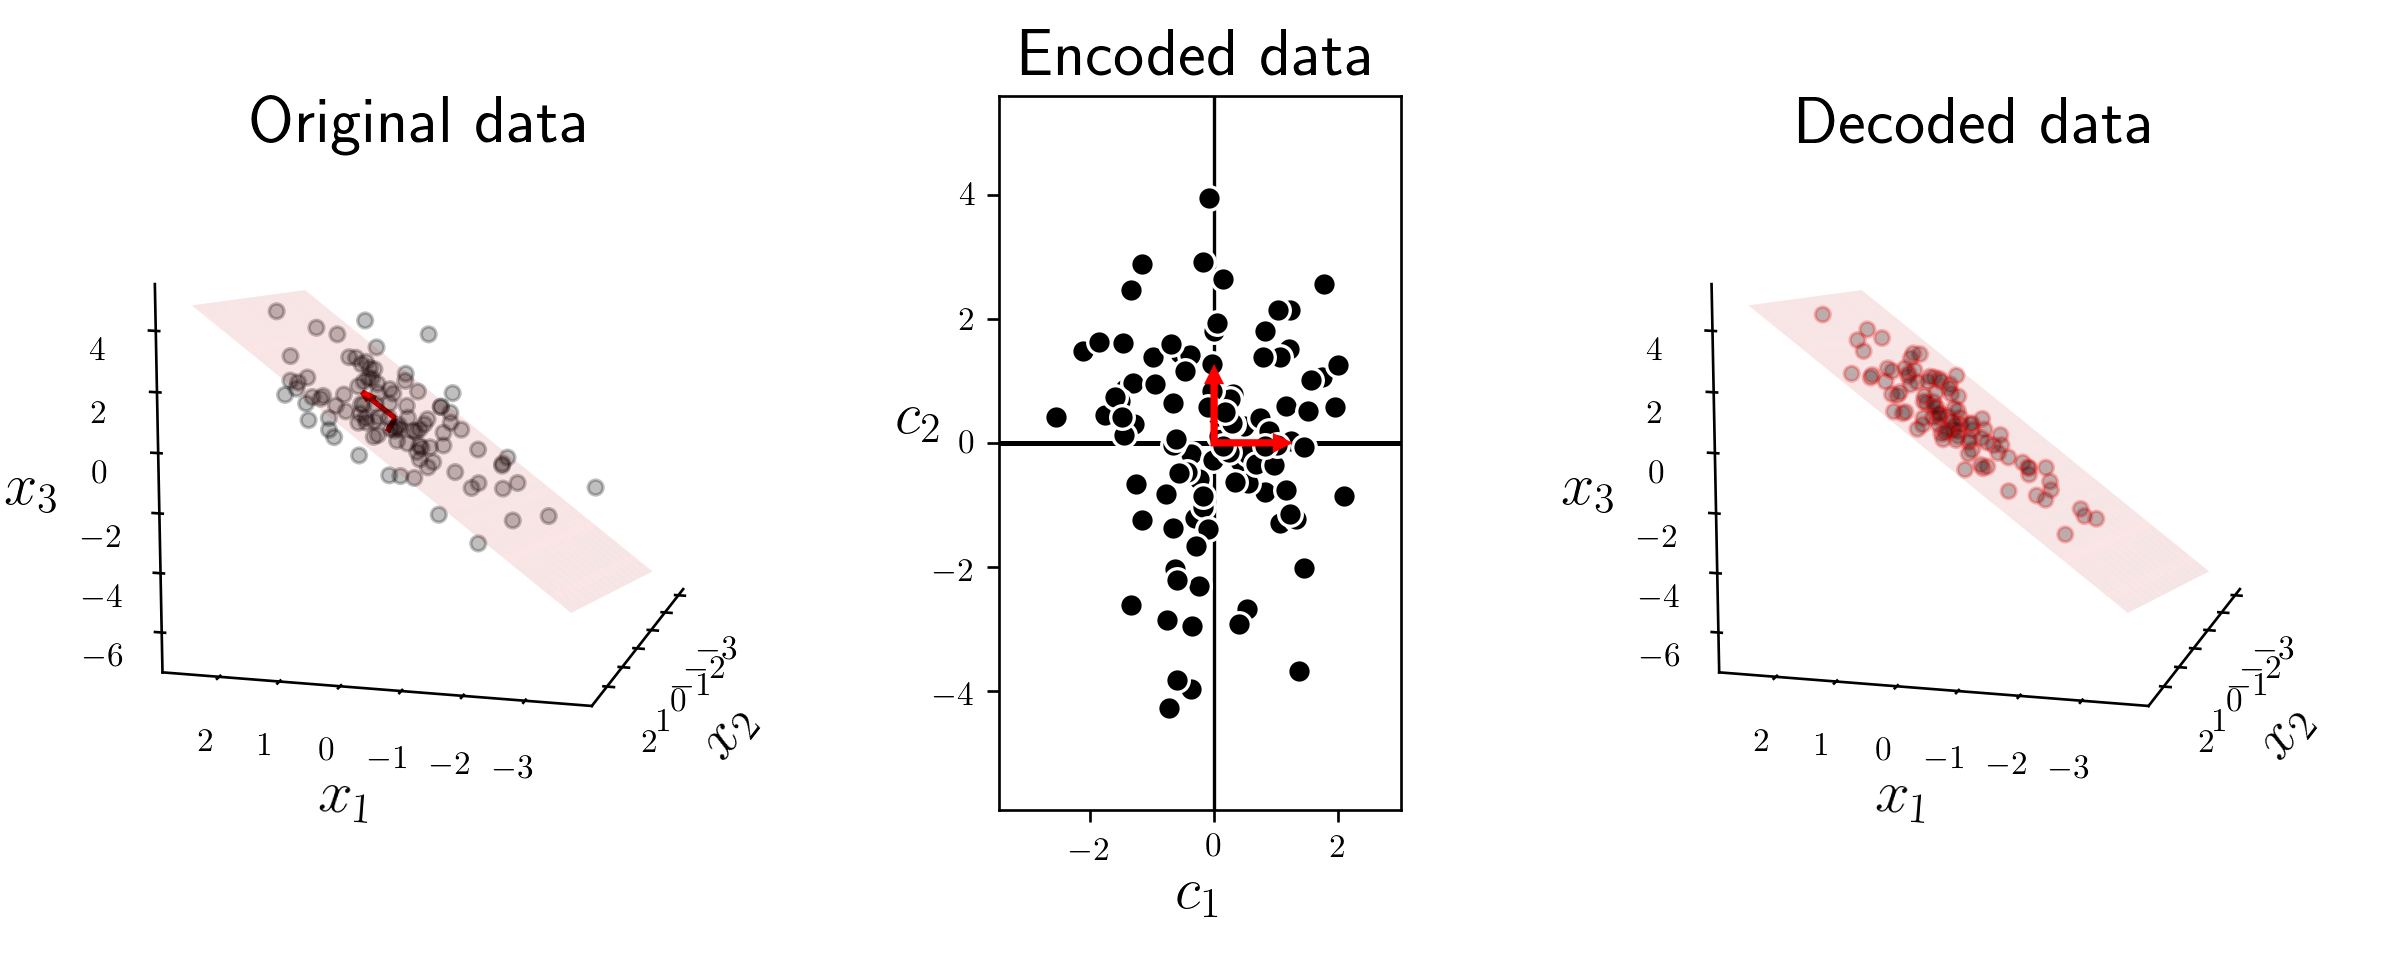

In [6]:
# load in dataset to perform PCA on
X_original = np.loadtxt(datapath + '3d_span_data.csv',delimiter=',')

# mean-center the data
X = center(X_original)

# compute the two-dimensional PCA transformation of dataset
W,C = pca_transform_data(X,num_components = 2)

# produce visuals
view = [15,105]
unsuplib.PCA_demos.project_data_from_3d_to_2d(X,C,view)

#### <span style="color:#a50e3e;">Example 3: </span> A warning about PCA dimension reduction and classification data

While PCA dimension reduction can technically be used for preprocessing data in a predictive modeling scenario - wherein the data is reduced in dimension in hopes of improving accuracy / computation time -  it can cause severe problems in the case of classification. In this Example we illustrate feature space dimension reduction via PCA on a simulated two-class dataset where the two classes are linearly separable. Because the ideal one-dimensional subspace in this instance runs parallel to the longer length of each class, projecting the complete dataset onto it completely destroys the separability. 

Because of this, while it is certainly common place to *sphere* classification data using PCA - as detailed in Example 6 - one needs to be extremely careful using PCA as a dimension reduction tool with classification.  

<figure>
  <img src= '../../mlrefined_images/unsupervised_images/Fig_9_7.png' width="75%" height="auto" alt=""/>
  <figcaption>   
<strong>Figure 3:</strong> <em> (left) A toy classification dataset consisting of two linearly separable classes. The ideal subspace produced via PCA is shown in black. (right) Projecting the data onto this subspace (in other words reducing the feature space dimension via PCA) destroys completely the original separability of the data.  </em>  </figcaption> 
</figure>

## 8.5.2  Formal derivation of the classic PCA solution to the autoencoder

From the previous Section we know that the minimizers of the Autoencoder cost function are all orthogonal.  Therefore the classic (orthogonal) PCA solution we compute below is indeed a global minimizer of the autoencoder.

To begin the derivation of the classic *Principal Components* solution to the Autoencoder all we must do is examine one summand of the Autoencoder cost function, under the assumption that $\mathbf{C}$ is orthogonal.  Expanding the of the $p^{th}$ summand we have

\begin{equation}
\left \Vert \mathbf{C}_{\,}\mathbf{C}^T\mathbf{x}_p - \mathbf{x}_p \right\Vert_2^2  =  \mathbf{x}_p^T \mathbf{C}^T \mathbf{C}\mathbf{C} \mathbf{C}^T \mathbf{x}_p   -2\mathbf{x}_p^T \mathbf{C}\mathbf{C}^T \mathbf{x}_p + \mathbf{x}_p^T \mathbf{x}_p
\end{equation}

and then using our assumption that $\mathbf{C}^T\mathbf{C}^{\,} = \mathbf{I}_{N\times N}$ we can see that it may be re-written equivalently as

\begin{equation}
 = -\mathbf{x}_p^T \mathbf{C}\mathbf{C}^T \mathbf{x}_p + \mathbf{x}_p^T \mathbf{x}_p = -\left\Vert \mathbf{C}^T\mathbf{x}_p \right\Vert_2^2 + \left \Vert\mathbf{x}_p\right \Vert_2^2.
\end{equation}

Since our aim is to *minimize* the summation of terms taking the form of the above, and the data point $\mathbf{x}_p$ is fixed and does not include the variable $\mathbf{C}$ we are minimizing with respect to, minimizing the original summand on the left is equivalent to minimizing *only the first term* $-\left\Vert \mathbf{C}^T\mathbf{x}_p \right\Vert_2^2$ on the right hand side.  Summing up these terms, the $p^{th}$ of which can be written decomposed over each individual basis element we aim to learn as

\begin{equation}
-\left\Vert \mathbf{C}^T\mathbf{x}_p \right\Vert_2^2 = -\sum_{n=1}^N \left(\mathbf{c}_n^T\mathbf{x}_p^{\,} \right)^2,
\end{equation}

gives us the following cost function (that is equivalent to the autoencoder under our assumption of orthogonality) to minimize for our ideal orthogonal basis

\begin{equation}
g\left(\mathbf{C}\right) = -\frac{1}{P}\sum_{p=1}^P \sum_{n=1}^K  \left(\mathbf{c}_n^T\mathbf{x}_p^{\,} \right)^2.
\end{equation}

Studying this reduced form of our Autoencoder cost function we can see that it *decomposes completely over the basis vectors $\mathbf{c}_n$*, i.e., there are no terms where $\mathbf{c}_i$ and $\mathbf{c}_j$ interact when $i\neq j$.  This means - practically speaking - that we can optimize our orthogonal basis *one element at a time*.  Reversing the order of the summands above we can isolate each individual basis element over the entire dataset, writing above equivalently as 

\begin{equation}
g\left(\mathbf{C}\right) = -\frac{1}{P}\sum_{n=1}^K \sum_{p=1}^P \left(\mathbf{c}_n^T\mathbf{x}_p^{\,} \right)^2.
\end{equation}

Now we can think about minimizing our cost function one basis element at a time.  Beginning with $\mathbf{c}_1$ we first isolate only those relevant terms above, which consists of: $-\frac{1}{P}\sum_{p=1}^P \left(\mathbf{c}_1^T\mathbf{x}_p^{\,}\right)^2$.    Since there is a minus sign out front of this summation, this is the same as *maximizing* its negation which we denote as

\begin{equation}
h\left(\mathbf{c}_1\right) = \frac{1}{P}\sum_{p=1}^P \left(\mathbf{c}_1^T\mathbf{x}_p^{\,} \right)^2.
\end{equation}

Since our basis is constrained to be orthogonal the basis element $\mathbf{c}_1$ in particular is constrained to have unit-length.  Statistically speaking, the above measures the *sample variance of the dataset in the direction defined by $\mathbf{c}_1$*.  Note: this quantity is precisely the sample variance because our data is assumed to have been *mean-centered*.  Since we aim to maximize this quantity we can phrase our optimization in purely sample statistical terms as well: we aim to recover the a form of the basis vector $\mathbf{c}_1$ that points in the maximum direction of variance in the dataset.  

To determine the maximum value of the function above / determine the direction of maximum sample variance in the data we can rewrite the formula above by stacking the data points $\mathbf{x}_p$ column-wise - forming the $N\times P$ matrix $\mathbf{X}$ - giving the equivalent formula in 

\begin{equation}
h\left(\mathbf{c}_1\right) = \frac{1}{P}\mathbf{c}_1^T \mathbf{X}^{\,}_{\,}\mathbf{X}^T_{\,} \mathbf{c}_1^{\,} = \mathbf{c}_1^T\left(\frac{1}{P}\mathbf{X}^{\,}_{\,}\mathbf{X}^T_{\,} \right)\mathbf{c}_1^{\,}.
\end{equation}

Written in this form the above takes the form of a so-called *Rayleigh Quotient*  whose maximum can is expressible algebraically in closed form based on the eigenvalue / eigenvector decomposition of the matrix $\mathbf{X}^{\,}\mathbf{X}^T$ (in the middle term) or likewise the matrix $\frac{1}{P}\mathbf{X}^{\,}\mathbf{X}^T$ (in the term on the right).  Because the matrix $\frac{1}{P}\mathbf{X}^{\,}\mathbf{X}^T$ can be interpreted statistically as the *covariance matrix* of the data it is more common to use the particular algebraic arrangement on the right.

So, denoting denoting $\mathbf{v}_1$ and $d_1$ the eigenvector and largest eigenvalue of $\frac{1}{P}\mathbf{X}^{\,}\mathbf{X}^T$ the maximum of the above occurs when $\mathbf{c}_1 = \mathbf{v}_1$, where $h\left(\mathbf{v}_1\right) = d_1$ - which is also the variance in this direction.  Remember: this direction $\mathbf{v}_1$ points in the largest direction of variance in the dataset.  In the jargon of machine learning $\mathbf{v}_1$ is referred to as the *first Principal Component* of the data, hence the name *Principal Component Analysis*.

With our first basis vector in hand, we can move on to determine the second element of our ideal orthogonal spanning set.  Plucking out the relevant terms from equation (37) and following the same thought process we went through above results in the familiar looking function

\begin{equation}
h\left(\mathbf{c}_2\right) = \frac{1}{P}\sum_{p=1}^P \left(\mathbf{c}_2^T\mathbf{x}_p^{\,} \right)^2
\end{equation}

that we aim to maximize in order to recover our second basis vector.  This formula has the same sort of statistical interpretation as the analogous version of the first basis vector had above - here again it calculates the variance of the data in the direction of $\mathbf{c}_2$.  Since our aim here is to maximize - given that $\mathbf{c}_1$ has already been resolved and that $\mathbf{c}_1^T\mathbf{c}_2^{\,} = 0$ due to our orthogonal assumption - the statistical interpretation here is that we are aiming to find the *second* largest orthogonal direction of sample variance in the data.

This formula can also be written in compact vector-matrix form as $h\left(\mathbf{c}_2\right) = \mathbf{c}_2^T \left(\frac{1}{P}\mathbf{X}^{\,}\mathbf{X}^T_{\,} \right)\mathbf{c}_2^{\,}$, and its maximum (given our restriction to an orthogonal basis implies that we must have $\mathbf{c}_1^T\mathbf{c}_2^{\,} = 0$) is again expressible in closed form in terms of the eigenvalue / eigenvector decomposition of the covariance matrix $\frac{1}{P}\mathbf{X}^{\,}\mathbf{X}^T$.  Here the same analysis leading to the proper form of $\mathbf{c}_1$ shows that the the maximum of the above occurs when $\mathbf{c}_2 = \mathbf{v}_2$ the eigenvector of $\frac{1}{P}\mathbf{X}^{\,}\mathbf{X}^T$ associated with its second largest eigenvalue $d_2$, and the variance in this direction is then $h\left(\mathbf{v}_2\right) = d_2$.  This ideal basis element / direction is referred to as the *second principal component of the data*.

More generally - following the same analysis for the $n^{th}$ member of our ideal orthonormal basis we look to maximize the familiar looking formula

\begin{equation}
h\left(\mathbf{c}_n\right) = \frac{1}{P}\sum_{p=1}^P \left(\mathbf{c}_n^T\mathbf{x}_p^{\,} \right)^2
\end{equation}

As with the first two cases above, the desire to maximize this quantity can be interpreted as the quest to uncover the $n^{th}$ orthogonal direction of sample variance in the data.  And following the same arguments, writing the above more compactly as $h\left(\mathbf{c}_n\right) = \mathbf{c}_n^T\left(\frac{1}{P} \mathbf{X}^{\,}\mathbf{X}^T_{\,}\right)\mathbf{c}_n^{\,}$ etc.,, we can show that it takes the form $\mathbf{c}_n = \mathbf{v}_n$, where $\mathbf{v}_n$ is the $n^{th}$ eigenvector of $\frac{1}{P}\mathbf{X}^{\,}\mathbf{X}^T$ associated with its $n^{th}$ largest eigenvalue $d_n$, and here the sample variance is expressible in terms of this eigenvalue $h\left(\mathbf{c}_n\right) = d_n$.  This is learned element / direction is referred to as the $n^{th}$ principal component of the data.